Need to upload:


*   kaggle.json


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 320M/330M [00:03<00:00, 37.5MB/s]
100% 330M/330M [00:04<00:00, 85.9MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('/content/face-mask-12k-images-dataset.zip', 'r')
zip_ref.extractall('/content/Face Mask Dataset')
zip_ref.close()

In [ ]:
test_dir = Path('/content/Face Mask Dataset/Face Mask Dataset/Test')
test_filepaths = list(test_dir.glob(r'**/*.png'))

train_dir = Path('/content/Face Mask Dataset/Face Mask Dataset/Train')
train_filepaths = list(train_dir.glob(r'**/*.png'))

val_dir = Path('/content/Face Mask Dataset/Face Mask Dataset/Validation')
val_filepaths = list(val_dir.glob(r'**/*.png'))

In [ ]:
def label_img(filepaths):
    labels = [str(filepath).split('/')[-2] for filepath in filepaths]
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label').astype(str)
    df = pd.concat([filepaths, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_df = label_img(train_filepaths)
test_df = label_img(test_filepaths)
val_df = label_img(val_filepaths)

In [ ]:
mobile_net_layers = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
mobile_net_layers.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile_net_layers.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
model = Sequential([
    mobile_net_layers,
    Flatten(),
    Dense(2, activation='sigmoid')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Data Generators
batch_size = 32

def generator(datagen, df):
    generator = datagen.flow_from_dataframe(
      df,
      x_col='Filepath',
      y_col='Label',
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='categorical')

    return generator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    zoom_range=0.3
)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = generator(train_datagen, train_df)
val_generator = generator(val_datagen, val_df)
test_generator = generator(test_datagen, test_df)

Found 10000 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.


In [ ]:
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
313/313 [==============================] - 598s 2s/step - loss: 0.0811 - accuracy: 0.9723 - val_loss: 0.0361 - val_accuracy: 0.9900
Epoch 2/10
313/313 [==============================] - 582s 2s/step - loss: 0.0347 - accuracy: 0.9892 - val_loss: 0.0277 - val_accuracy: 0.9912
Epoch 3/10
313/313 [==============================] - 572s 2s/step - loss: 0.0280 - accuracy: 0.9901 - val_loss: 0.0234 - val_accuracy: 0.9925
Epoch 4/10
313/313 [==============================] - 563s 2s/step - loss: 0.0234 - accuracy: 0.9927 - val_loss: 0.0233 - val_accuracy: 0.9937
Epoch 5/10
313/313 [==============================] - 603s 2s/step - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.0176 - val_accuracy: 0.9937
Epoch 6/10
313/313 [==============================] - 566s 2s/step - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.0146 - val_accuracy: 0.9950
Epoch 7/10
313/313 [==============================] - 559s 2s/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0177 - val_accuracy: 0.9937

31/31 [==============================] - 40s 1s/step - loss: 0.0119 - accuracy: 0.9950
Test Accuracy: 0.9949596524238586


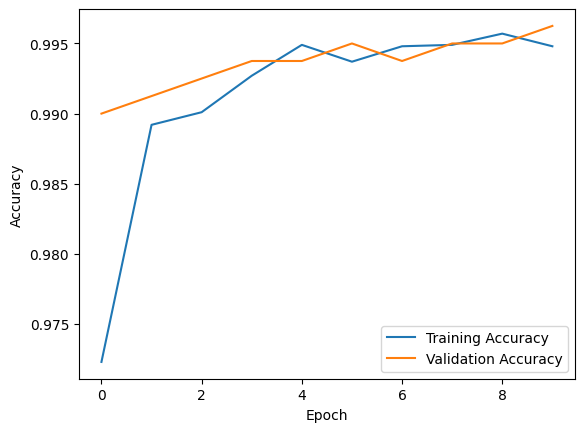

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# drive.mount('/content/drive')
model.save("mask_detect.h5")
files.download("mask_detect.h5")

